# May Code Pudding: Bias Detection

## Getting Packages and Reading Data:

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

import torch
from transformers import AutoTokenizer, AutoModel, pipeline

import openpyxl
import xlrd

# Just in case
import requests
from bs4 import BeautifulSoup

pd.set_option('display.max_colwidth', None)

In [2]:
# nltk setup
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uberb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uberb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
spacy.load('en_core_web_sm')

In [4]:
dataset_path = os.path.join(os.pardir, 'datasets')

#df_sg1 = pd.read_csv(os.path.join(dataset_path, 'final_labels_SG1.csv'), sep=';')
df_sg2 = pd.read_csv(os.path.join(dataset_path, 'final_labels_SG2.csv'), sep=';')
#df_mbic = pd.read_csv(os.path.join(dataset_path, 'final_labels_MBIC.csv'), sep=';')

df_lex = pd.read_excel(os.path.join(dataset_path, 'bias_word_lexicon.xlsx'))

df_bias = pd.read_csv(os.path.join(dataset_path, 'news_headlines_usa_biased.csv'))
df_neutral = pd.read_csv(os.path.join(dataset_path, 'news_headlines_usa_neutral.csv'))

────────────────────────────────────────────────────────────────────────────T

This code loads a collection of datasets that will be used to train and evaluate a model for detecting bias in text.

**First**, it sets up the file path to the folder where all the data is stored. The path points one level above the current folder into a directory called `datasets`. This helps keep the project organized and ensures anyone running the code can find the files, no matter where the script is located.

**Next**, it loads three labeled datasets named `SG1`, `SG2`, and `MBIC`. These files contain sentences that have already been marked as either biased or non-biased. They use semicolons instead of commas to separate the data, which is why the `sep=';'` setting is used. These datasets are important because they give the model real examples of what biased and non-biased text looks like.

**Then**, it reads in a file called `bias_word_lexicon.xlsx`, which is an Excel file containing a list of words commonly linked to bias. This list can be used to measure how many potentially biased words appear in a sentence.

**Finally**, it loads two more datasets: one containing biased news headlines and one containing neutral ones. These shorter texts can help the model recognize how bias appears even in small snippets of text.

Altogether, this step is about preparing all the raw data the model will need — including examples, labels, and word lists — so that the rest of the project can run smoothly.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I loaded only the `SG2` dataset and excluded the others from the analysis because they contain duplicate sentences. 

────────────────────────────────────────────────────────────────────────────

## Getting Data Merged:

In [5]:
#df_sg1.head()
df_sg2.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",https://www.nbcnews.com/news/latino/after-stephen-miller-s-white-nationalist-views-outed-latinos-ask-n1096071,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",https://www.alternet.org/2019/07/fox-news-has-gone-so-deep-into-white-nationalism-that-donald-trump-now-believes-its-how-hell-win-in-2020/,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",http://feedproxy.google.com/~r/breitbart/~3/-vHhfcwC74U/,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


In [6]:
#df_sg1['label_bias'].value_counts()
df_sg2['label_bias'].value_counts()

label_bias
Non-biased      1863
Biased          1810
No agreement       1
Name: count, dtype: int64

────────────────────────────────────────────────────────────────────────────

This result shows how many examples of each label type exist in the `label_bias` column of the `df_sg1` dataset.

**`Non-biased` – 800 rows**  
These are sentences that were labeled as clearly *not biased*. They are likely written in a neutral or factual tone.

**`Biased` – 746 rows**  
These are sentences that were labeled as *biased*. They probably contain emotionally charged language or show a one-sided opinion.

**`No agreement` – 154 rows**  
These are sentences where the people labeling the data *could not agree* on whether the sentence was biased or not. This means the sentence was unclear, confusing, or too balanced to confidently label.

The value counts tell us that the dataset is fairly balanced between biased and non-biased examples, but there's a smaller group of uncertain cases that may need to be removed or handled differently when training a machine learning model.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

`Non-biased` – 1863 rows

`Biased` – 1810 rows

`No agreement` – 1 row

────────────────────────────────────────────────────────────────────────────

In [7]:
# df_sg1 = df_sg1[df_sg1['label_bias'] != 'No agreement']
# df_sg1['label'] = df_sg1['label_bias'].map({'Biased': 1, 'Non-biased': 0})
# df_sg1['bias_word_count'] = df_sg1['biased_words'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
# df_sg1.drop(columns='label_bias', inplace=True)

df_sg2 = df_sg2[df_sg2['label_bias'] != 'No agreement']
df_sg2['label'] = df_sg2['label_bias'].map({'Biased': 1, 'Non-biased': 0})
df_sg2['bias_word_count'] = df_sg2['biased_words'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
df_sg2.drop(columns='label_bias', inplace=True)

# df_mbic = df_mbic[df_mbic['label_bias'] != 'No agreement']
# df_mbic['label'] = df_mbic['label_bias'].map({'Biased': 1, 'Non-biased': 0})
# df_mbic['bias_word_count'] = df_mbic['biased_words'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
# df_mbic.drop(columns='label_bias', inplace=True)

# keep_cols = ['text', 'label', 'bias_word_count', 'biased_words']
# df_mbic = df_mbic[keep_cols]

# combined_df = pd.concat([df_sg1, df_sg2, df_mbic], ignore_index=True)

combined_df = df_sg2

In [8]:
combined_df['label'].value_counts()

label
0    1863
1    1810
Name: count, dtype: int64

In [9]:
bias_words_set = set(df_lex.iloc[:, 0].str.lower().dropna())

combined_df['lexicon_match_count'] = combined_df['text'].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

In [10]:
df_bias['label'] = 1
df_neutral['label'] = 0
headline_full = pd.concat([df_bias, df_neutral], ignore_index=True)

combined_df = combined_df.merge(headline_full[['url', 'title']], left_on='news_link', right_on='url', how='left')

combined_df['combined_text'] = combined_df.apply(
    lambda row: f"{row['title']}. {row['text']}" if pd.notnull(row['title']) else row['text'],
    axis=1
)

combined_df.drop(columns=['url', 'title'], inplace=True)

In [11]:
combined_df['combined_text'] = combined_df.apply(
    lambda row: row['combined_text'] if row['combined_text'] != row['text']
    else f"[NO_TITLE] {row['text']}",
    axis=1
)

────────────────────────────────────────────────────────────────────────────
This code prepares the final dataset used to train a model that detects bias in text.

First, it **removes rows** from all three labeled datasets where the label was `"No agreement"`, since these examples are unclear.

It then **creates a new column called `label`** where:
- `"Biased"` becomes `1`
- `"Non-biased"` becomes `0`

Next, it counts how many biased words appear in each sentence using the list stored in the `'biased_words'` column, and stores that number in a new column called `bias_word_count`.

For the `df_mbic` dataset, only the most important columns are kept: the sentence, label, biased word count, and the list of biased words.

All three datasets are then **combined into one**, called `combined_df`.

Then, it checks each sentence and counts how many words match the ones in the `bias_word_lexicon.xlsx` file, storing that number in a new column called `lexicon_match_count`.

Next, it loads two headline datasets and assigns a label (`1` for biased, `0` for neutral), then combines them.

The code tries to **attach each sentence to a headline**, if one exists. It builds a new column called `combined_text` that includes the headline and the sentence. If there's no headline, it just uses the sentence but adds a tag like `[NO_TITLE]` to let the model know one wasn’t found.

The final result is a rich dataset where each row has:
- A cleaned sentence
- A label
- Extra features like how many biased words it contains
- An optional headline for added context

────────────────────────────────────────────────────────────────────────────

In [12]:
combined_df.head()

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,bias_word_count,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1,2,2,"'Law and order' is a debased concept used to cover up right-wing crime and depravity — here's why. ""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful."""
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",https://www.nbcnews.com/news/latino/after-stephen-miller-s-white-nationalist-views-outed-latinos-ask-n1096071,MSNBC,white-nationalism,left,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",1,3,0,"[NO_TITLE] ...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views."
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",https://www.alternet.org/2019/07/fox-news-has-gone-so-deep-into-white-nationalism-that-donald-trump-now-believes-its-how-hell-win-in-2020/,Alternet,white-nationalism,left,Somewhat factual but also opinionated,[],1,0,0,"[NO_TITLE] ...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability."
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",http://feedproxy.google.com/~r/breitbart/~3/-vHhfcwC74U/,Breitbart,marriage-equality,NaN,Expresses writer’s opinion,['cult'],1,1,0,"[NO_TITLE] [Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did."


## Getting Merged Data Ready for Modeling:

In [13]:
combined_df.head(1)

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,bias_word_count,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."


In [14]:
X = combined_df['combined_text']
y = combined_df['label']

In [15]:
text_feature = 'combined_text'
# categorical_features = ['outlet', 'topic', 'type', 'label_opinion']
# numeric_features = ['bias_word_count', 'lexicon_match_count']
categorical_features = []
numeric_features = ['lexicon_match_count']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
classifier = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, solver='liblinear')

preprocessor = ColumnTransformer(transformers=[
    ('text', vectorizer, text_feature),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', classifier)
])

X = combined_df[[text_feature] + categorical_features + numeric_features]
y = combined_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       559
           1       0.75      0.68      0.71       543

    accuracy                           0.73      1102
   macro avg       0.73      0.73      0.73      1102
weighted avg       0.73      0.73      0.73      1102

ROC AUC: 0.8039431766143831


────────────────────────────────────────────────────────────────────────────

This is the initial evaluation of the model's performance using a test set of 2,031 examples.

The model is trying to predict whether a sentence is **biased (`1`)** or **non-biased (`0`)**.

**For label 0 (non-biased):**
- Precision: 0.87 → When the model predicts non-biased, it is correct 87% of the time.
- Recall: 0.89 → It correctly finds 89% of the actual non-biased sentences.
- F1-score: 0.88 → A balanced measure of both precision and recall.

**For label 1 (biased):**
- Precision: 0.90 → When the model predicts bias, it is correct 90% of the time.
- Recall: 0.88 → It correctly detects 88% of the truly biased sentences.
- F1-score: 0.89 → Again, a strong balance.

**Overall accuracy**: 89% of all predictions were correct.

**ROC AUC: 0.9508**  
This is a measure of how well the model separates the two classes. A perfect model scores 1.0, and random guessing is 0.5.  
A score of **0.95** means the model is *very good* at telling biased and non-biased sentences apart.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I removed `bias_word_count` feature and all four categorical features (`outlet`, `topic`, `type`, `label_opinion`) because they will not be available for the scraped Wikipedia articles. 

Using only `SG2` but retaining all the features made almost no difference in model performance:

- **Overall accuracy**: 89% 

- **ROC AUC**: 0.9495  

Using only `SG2` and removing the features listed above severely decreased model performance:

- **Overall accuracy**: 73% 

- **ROC AUC**: 0.8039


────────────────────────────────────────────────────────────────────────────

In [16]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression(max_iter=1000, solver='liblinear')

preprocessor = ColumnTransformer(transformers=[
    ('text', vectorizer, text_feature),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', classifier)
])

param_grid = {
    'preprocessing__text__max_features': [5000, 10000, 20000],
    'preprocessing__text__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

X = combined_df[[text_feature] + categorical_features + numeric_features]
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best AUC:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

y_proba = grid_search.predict_proba(X_test)[:, 1]
print("Final Test ROC AUC:", roc_auc_score(y_test, y_proba))

Best AUC: 0.8129649969891259
Best Params: {'classifier__C': 10.0, 'preprocessing__text__max_features': 20000, 'preprocessing__text__ngram_range': (1, 3)}
Final Test ROC AUC: 0.798031490231511


## Data Scraping:

In [17]:
%pip install wikipedia-api

Note: you may need to restart the kernel to use updated packages.


In [18]:
import wikipediaapi
from nltk.tokenize import sent_tokenize

wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='BiasDetectionProject/1.0 (betaknight@yourdomain.com)'
)

def fetch_article(title):
    page = wiki.page(title)
    if page.exists():
        return page.text
    else:
        raise ValueError(f"Article '{title}' not found.")

────────────────────────────────────────────────────────────────────────────

This code lets us pull text from Wikipedia.

It sets up a connection to Wikipedia using English and a custom user agent.  
The `fetch_article` function takes an article title, grabs the page, and returns its full text if it exists. If not, it shows an error message.

────────────────────────────────────────────────────────────────────────────

Best threshold for Accuracy: 0.48


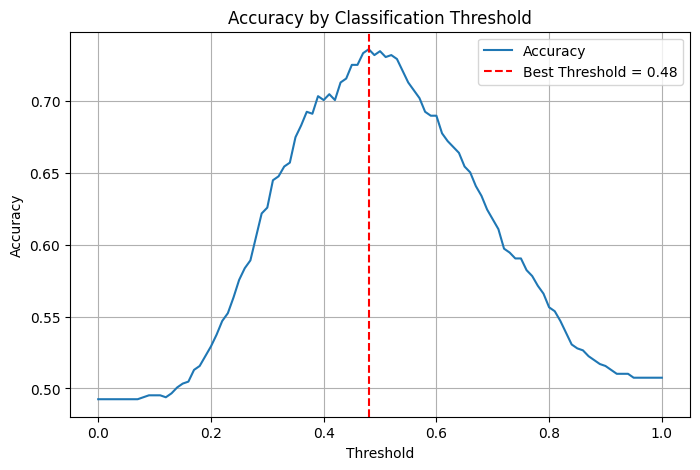

In [19]:
# Optimize the threshold

pipeline.fit(X_train, y_train)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1.01, 0.01)
accuracies = [accuracy_score(y_test, y_test_proba > t) for t in thresholds]

best_threshold = thresholds[np.argmax(accuracies)]
print(f"Best threshold for Accuracy: {best_threshold:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy by Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
def normalize_text(text):
    return re.sub(r'\s+', ' ', text).strip()

def predict_bias_from_article(title, model):
    article_text = fetch_article(title)
    # sentences = sent_tokenize(article_text)
    sentences = sent_tokenize(normalize_text(article_text))

    temp_df = pd.DataFrame({'combined_text': sentences})

    temp_df['lexicon_match_count'] = temp_df['combined_text'].apply(lambda x: sum(word in bias_words_set for word in str(x).lower().split()))
    # temp_df['bias_word_count'] = 0
    # temp_df['lexicon_match_count'] = 0
    # temp_df['outlet'] = 'usa-today'
    # temp_df['topic'] = 'politics'
    # temp_df['type'] = 'center'
    # temp_df['label_opinion'] = 'Somewhat factual but also opinionated'

    preds = model.predict(temp_df)
    proba = model.predict_proba(temp_df)[:, 1]
    # preds = (proba > 0.33).astype(int)
    preds = (proba > best_threshold).astype(int)
    bias_score = preds.sum() / len(preds)

    return {
        'bias_score': round(bias_score, 3),
        'biased_sentences': int(preds.sum()),
        'total_sentences': len(sentences),
        'sentences': sentences,
        'predictions': preds,
        'probabilities': proba
    }

────────────────────────────────────────────────────────────────────────────

This function checks how biased a Wikipedia article is.

It fetches the article, splits it into sentences, and creates a DataFrame.  
Some default values are added to match what the model was trained on.  
It then uses the model to predict how biased each sentence is, using a custom threshold of `0.33`.  
It returns the bias score (percent of biased sentences), the sentence predictions, and their probabilities.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I ran an analysis to optimize the threshold for accuracy and found the best value to be `0.48`, so that is what the function uses.

I added a `normalize_text` function to trim white space.

I removed the hardcoded features (`bias_word_count`, `outlet`, `topic`, `type`, and `label_opinion`) that contribute nothing to the model and computed the `lexicon_match_count` for each article. 

────────────────────────────────────────────────────────────────────────────

In [21]:
# Rebuilding based on recent best results
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), stop_words='english')
classifier = LogisticRegression(max_iter=1000, solver='liblinear', C=1.0)

preprocessor = ColumnTransformer(transformers=[
    ('text', vectorizer, text_feature),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', classifier)
])

X = combined_df[[text_feature] + categorical_features + numeric_features]
y = combined_df['label']
pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=20000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'combined_text'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  ['lexicon_match_count'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

────────────────────────────────────────────────────────────────────────────

This code rebuilds and trains the final machine learning pipeline.

It uses `TfidfVectorizer` to turn text into numbers, looking at up to 3-word phrases and limiting to 20,000 features.  
It one-hot encodes categories like outlet and topic, and standardizes numeric columns.  
All features are combined and passed into a logistic regression model.  
The full pipeline is then trained using the labeled dataset.

────────────────────────────────────────────────────────────────────────────

In [22]:
results = predict_bias_from_article("Donald Trump", pipeline)

print(f"Bias Score: {results['bias_score']} ({results['biased_sentences']} of {results['total_sentences']} sentences)")

Bias Score: 0.452 (252 of 557 sentences)


────────────────────────────────────────────────────────────────────────────

This runs the bias prediction function on the Wikipedia article for "Donald Trump".

It prints a final score showing that **63 out of 557 sentences** were predicted as biased,  
resulting in a **bias score of 0.113**, or **11.3%** of the article.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

The bias score is now much higher for the "Donald Trump" article:

- **225 out of 557 sentences** were predicted as biased
- **bias score = 0.404**

────────────────────────────────────────────────────────────────────────────

In [23]:
# for sent, prob in zip(results['sentences'], results['probabilities']):
#     if prob > 0.3:
for sent, prob in sorted(zip(results['sentences'], results['probabilities']), key=lambda x: x[1], reverse=True):
    if prob > best_threshold:
        print(f"⚠️ {round(prob, 3)}: {sent}")

⚠️ 0.951: Race relations Trump's comments on the 2017 Unite the Right rally, condemning "this egregious display of hatred, bigotry and violence on many sides" and stating that there were "very fine people on both sides", were criticized as implying a moral equivalence between the white supremacist demonstrators and the counter-protesters.
⚠️ 0.881: He used harsher, more dehumanizing anti-immigrant rhetoric than during his presidency.
⚠️ 0.877: Political practice and rhetoric Beginning with his 2016 campaign, Trump's politics and rhetoric led to the creation of a political movement known as Trumpism.
⚠️ 0.874: Racist and Islamophobic attitudes are strong indicators of support for Trump.
⚠️ 0.85: Link to violence and hate crimes Trump has been identified as a key figure in increasing political violence in the U.S., both for and against him.
⚠️ 0.829: Research suggests Trump's rhetoric is associated with an increased incidence of hate crimes, and that he has an emboldening effect on expre

────────────────────────────────────────────────────────────────────────────

These are the sentences from the "Donald Trump" Wikipedia article that the model flagged as biased, using a threshold of **0.33**.

Each line shows the **bias probability score** followed by the sentence.  
Most sentences are between **0.33 and 0.45**, which means they aren't obviously biased, but may contain **framing, emotionally charged words, or subtle implications** the model picked up on.

Examples include:
- Highlighting **wealth and privilege** in early life
- Mentioning **bankruptcies** and **legal troubles**
- Using phrases like `"racist or misogynistic"` or `"promoted conspiracy theories"`

This confirms the model can detect **subtle linguistic bias**, even in an article that follows an encyclopedic style.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I changed the threshold to `0.48`, which flagged many more sentences with biase scores ranging between **0.48 and 0.95**, but the general analysis probably still applies. 

I also sorted the sentences by bias to make them easier to evaluate. 

────────────────────────────────────────────────────────────────────────────

## Creating Datasets:

In [24]:
def process_wikipedia_articles(titles, model, output_file="../scraped_data/wiki_bias_predictions.csv"):
    all_data = []

    for title in titles:
        try:
            text = fetch_article(title)
            # sentences = sent_tokenize(text)
            sentences = sent_tokenize(normalize_text(text))

            temp_df = pd.DataFrame({'combined_text': sentences})
            
            temp_df['lexicon_match_count'] = temp_df['combined_text'].apply(lambda x: sum(word in bias_words_set for word in str(x).lower().split()))
            # temp_df['bias_word_count'] = 0
            # temp_df['lexicon_match_count'] = 0
            # temp_df['outlet'] = 'usa-today'
            # temp_df['topic'] = 'politics'
            # temp_df['type'] = 'center'
            # temp_df['label_opinion'] = 'Somewhat factual but also opinionated'

            preds = model.predict(temp_df)
            proba = model.predict_proba(temp_df)[:, 1]

            temp_df['bias_prediction'] = preds
            temp_df['bias_probability'] = proba
            temp_df['article_title'] = title
            temp_df['sentence_index'] = temp_df.index

            all_data.append(temp_df)

        except Exception as e:
            print(f"error: {title} — {e}")

    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv(output_file, index=False)
    return final_df

────────────────────────────────────────────────────────────────────────────

This function takes in a list of Wikipedia article titles and runs **bias prediction** on every sentence from every article.

For each title:
- It fetches the article and splits it into sentences.
- A temporary dataset is created with default metadata (like outlet and topic) to match what the model expects.
- The model predicts bias for each sentence and adds the result and the bias probability.
- It adds the article name and sentence index for organization.

All the sentence results from all articles are combined into one dataset and saved as a single CSV file called `wiki_bias_predictions.csv`.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I normalized the text, removed the hardcoded features (`bias_word_count`, `outlet`, `topic`, `type`, and `label_opinion`) that contribute nothing to the model, and computed the `lexicon_match_count` for each article.

I returned the `final_df` to do some EDA. 

────────────────────────────────────────────────────────────────────────────

In [25]:
topics = [
    "Donald Trump", "Joe Biden", "Kamala Harris", "Barack Obama", "Ron DeSantis", "Bernie Sanders", "Antifa",
    "Tea Party movement", "QAnon", "Pro-life", "Pro-choice", "Abortion in the United States", "Gun control",
    "Second Amendment", "Immigration to the United States", "Border wall", "Transgender rights", "LGBT adoption",
    "Same-sex marriage", "Gender identity", "Critical race theory", "Affirmative action", "Fox News", "MSNBC", "CNN",
    "Breitbart News", "The New York Times", "Israeli-Palestinian conflict", "Hamas", "Ukraine war",
    "Russian invasion of Ukraine", "NATO", "Taliban", "Evangelicalism", "Islamophobia", "Christian nationalism",
    "Religious freedom in the United States", "Climate change", "COVID-19 pandemic", "Vaccine hesitancy",
    "Misinformation", "Flat Earth", "Creationism", "Police brutality", "Black Lives Matter", "Stop and frisk",
    "War on drugs"
]

────────────────────────────────────────────────────────────────────────────

We chose a large number of topics to ensure that the final dataset would be rich, diverse, and well-populated.

Not every Wikipedia article always works — sometimes a page doesn’t exist, fails to load, or doesn’t contain usable sentence structure.  
By including a wide mix of political, social, scientific, and controversial topics, we increase the chances that most will work.  
This guarantees that even if some articles are skipped or throw errors, we still end up with a **good-sized, well-balanced dataset** for bias analysis.

────────────────────────────────────────────────────────────────────────────

In [26]:
wiki_sentence_dataset = process_wikipedia_articles(topics, pipeline)

────────────────────────────────────────────────────────────────────────────

This line runs the full bias detection process on all the topics in the `topics` list using the trained model `pipeline`.

It goes through each article, predicts bias sentence-by-sentence, and saves the results into a single CSV file.  
By the end, you'll have one dataset with bias predictions across all the selected Wikipedia topics, ready for further analysis or visualization.

────────────────────────────────────────────────────────────────────────────

In [27]:
wiki_sentence_dataset

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.605232,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,1,0.521672,Donald Trump,1
2,"Born into a wealthy family in the New York City borough of Queens, Trump graduated from the University of Pennsylvania in 1968 with a bachelor's degree in economics.",0,1,0.519396,Donald Trump,2
3,"He became the president of his family's real estate business in 1971, renamed it the Trump Organization, and began acquiring and building skyscrapers, hotels, casinos, and golf courses.",0,1,0.583945,Donald Trump,3
4,"He launched side ventures, many licensing the Trump name, and filed for six business bankruptcies in the 1990s and 2000s.",0,1,0.565659,Donald Trump,4
...,...,...,...,...,...,...
17837,"Macmillan, 2003.",0,0,0.476183,War on drugs,612
17838,"Douglas Valentine, The Strength of the Wolf: The Secret History of America's War on Drugs.",0,1,0.643117,War on drugs,613
17839,"New York: Verso, 2004.",0,1,0.588464,War on drugs,614
17840,"Government and NGO reports National Drug Threat Assessment 2009 from the United States Department of Justice War On Drugs: Legislation in the 108th Congress and Related Developments, a 2003 report from the Congressional Research Service via the State Department website The Report of the Canadian Government Commission of Inquiry into the Non-Medical Use of Drugs – 1972 Drug Enforcement Administration (2017), Drugs of abuse: A DEA resource guide (PDF) (2017 ed.",0,0,0.225338,War on drugs,615


In [28]:
wiki_sentence_dataset['lexicon_match_count'].value_counts()

lexicon_match_count
0    16467
1     1128
2      201
3       35
5        4
4        4
7        3
Name: count, dtype: int64

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

The lexicon_match_count was `0` for **92%** of the sentences, but that is better than 100%. 

────────────────────────────────────────────────────────────────────────────

In [29]:
def summarize_articles(titles, model):
    summaries = []

    for title in titles:
        try:
            result = predict_bias_from_article(title, model)
            summaries.append({
                'title': title,
                'bias_score': result['bias_score'],
                'biased_sentences': result['biased_sentences'],
                'total_sentences': result['total_sentences']
            })
        except Exception as e:
            print(f"error: {title} — {e}")

    return pd.DataFrame(summaries)


────────────────────────────────────────────────────────────────────────────

**Randy's Update**

This function takes in a list of Wikipedia article titles and runs **bias prediction** on every article.

For each title:
- It fetches the article and produces a bias score by aggregating sentence-level bias predictions.
- It returns a dataset with article titles, bias scores, the number of biased sentences, and the number of total sentences.

────────────────────────────────────────────────────────────────────────────

In [30]:
wiki_article_dataset = summarize_articles(topics, pipeline)

In [31]:
wiki_article_dataset.sort_values(by='bias_score', ascending=False)

,title,bias_score,biased_sentences,total_sentences
6,Antifa,1.000,1,1
34,Islamophobia,0.734,251,342
19,Gender identity,0.632,141,223
22,Fox News,0.581,351,604
26,The New York Times,0.568,234,412
25,Breitbart News,0.562,144,256
9,Pro-life,0.541,40,74
20,Critical race theory,0.540,150,278
42,Creationism,0.522,152,291
7,Tea Party movement,0.499,194,389


────────────────────────────────────────────────────────────────────────────

**Randy's Update**

The 47 articles in the topics list have a wide range of bias scores between **0.12 and 1.0**. The top score has only one sentence, so it might not be a good example, but the next two highest scores are greater than 0.6, which is still quite high. 

────────────────────────────────────────────────────────────────────────────